<a href="https://colab.research.google.com/github/OmarAlejandroLinares/Simpson-CNN-MLP-Classification/blob/master/simpson_clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de la base de datos

Este trabajo permite cargar los datos procesados e implementarlos en una Red Neuronal Convolucional a través de TF2.

Los resultados obtenidos en 25 épocas fueron de:
* Exactitud en el entrenamiento: 0.980687026977539
* Pérdida en el entrenamiento: 0.06393703073263168
* Exactitud en la prueba: 0.702837142944336 
* Pérdida en la prueba: 2.7027971744537354

## Importar librerías

In [1]:
#Cargamos las librerías para manejo de matrices, gráficas y preprocesamiento...
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pickle
import random
%matplotlib inline

## Cargar dataset creado

In [2]:
# Se monta drive personal
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Separando el conjunto de datos en imágenes y etiquetas

In [3]:
# Se cargan los dos archivos .pickle creados anteriormente
path= "/content/drive/MyDrive/simpsons/"
with open(path+"simpsons_set0.pickle",'rb') as f:
  datos_x,datos_y = pickle.load(f)

In [4]:
# Imágenes
datos_x.shape

(13679, 80, 80, 3)

In [5]:
# Etiquetas
datos_y.shape

(13679, 10)

## Declarar arquitectura de la red con TF2

El agregar un incializador no random permite que, como comentamos en el análisis de la tarea anterior, mejore en gran medida los resultados obtenidos por la

In [6]:
class DNN_model(tf.Module):
  # Inicializa el objeto con todo aquello dentro del def __init__
  def __init__(self,
               n_classes=10):
    #Todos los parametros son tf.Variable.

    # Declarando inicializador
    self.inicial = tf.initializers.glorot_uniform(seed=1)

    # Primera capa
    self.h1LW = tf.Variable(self.inicial((5,5,3,32)))
    self.h1LB = tf.Variable(self.inicial((32,)))

    # Segunda capa
    self.h2LW = tf.Variable(self.inicial((5,5,32,32)))
    self.h2LB = tf.Variable(self.inicial((32,)))

    # Tercera capa
    self.h3LW = tf.Variable(self.inicial((20*20*32,64)))    
    self.h3LB = tf.Variable(self.inicial((64,)))

    # Cuarta capa
    self.outW = tf.Variable(self.inicial((64, n_classes)))
    self.outB = tf.Variable(self.inicial((n_classes,)))    
  
  def __call__(self,x):
      # Formato a la entrada de 80 x 80 x 3
      x  = tf.cast(x, tf.float32)      
      img = tf.reshape(x, shape=[-1, 80, 80, 3])

      # Primera capa convolucional para 40 x 40 x 32
      l1= tf.nn.conv2d(img,self.h1LW, strides=[1,1,1,1], padding='SAME')  
      l1 = tf.nn.relu(tf.add(l1, self.h1LB))    
      l1 = tf.nn.max_pool(l1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

      # Segunda capa convolucional para 20 x 20 x 32
      l2= tf.nn.conv2d(l1,self.h2LW, strides=[1,1,1,1], padding='SAME')  
      l2 = tf.add(l2, self.h2LB)
      l2 = tf.nn.relu(l2)
      l2 = tf.nn.max_pool(l2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
  
      # Tercera capa (dimensión de 64) 
      l3=  tf.reshape(l2,[-1, 20*20*32])
      l3=  tf.matmul(l3,self.h3LW)
      l3 = tf.nn.relu(tf.add(l3, self.h3LB))

      # Salida de la red (dimensión de 10)
      output = tf.matmul(l3,self.outW) + self.outB

      return output
      #Cada vez que llamemos a la red, se ejecuta la propagación hacia adelante

In [7]:
# Creando un objeto DNN_model()
DNN = DNN_model()
#Mandamos a llamar la propagación hacia adelante del objeto DNN
DNN(datos_x[0])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ -25.130285 ,   33.44004  ,   10.628458 ,  -55.172993 ,
         -65.7736   ,  -32.88443  , -187.12755  ,   -2.3098874,
          82.736565 ,   -6.317874 ]], dtype=float32)>

Seleccionando un optimizador

Antes de que el modelo este listo para entrenar , se necesitan algunas configuraciones más. Éstas son agregadas durante el paso de compilacion del modelo:

+ Loss function: Mide qué tan exacto es el modelo. Se busca minimizar su valor para dirigir el modelo en la dirección adecuada.
+ Optimizer: Cómo el modelo se actualiza basado en el set de datos que ve y la función de pérdida. Por default el factor de aprendizaje es de 0.001
+ Metrics: Métricas de validación, monitorean los pasos de entrenamiento y pruebas. El accuracy (exactitud), arroja la fración de entradas correctamente clasificadas.

In [8]:
# Declarando el optimizador
optimizador = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001)

# Se eligió el que mejores resultados de exactitud otorgó.
# Aunque se especifica el larning_rate, el valor que tiene es el de default

Definiendo las métricas

In [9]:
# Funciones de costo
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

# Funciones de exactitud
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

Cálculo de gradientes y ajuste

In [10]:
#Declaramos el paso de entrenamiento
def train_step(model,tdata, labels):
  # Esta funcion recibe el modelo, los datos de entrenamiento y sus etiquetas
  with tf.GradientTape() as tape:
    # Cargamos el calculo de gradiente de tensorflow y lo renombramos como tape (la cinta del gradiente)
    # Hacemos la propagacion hacia delante de los datos de entrenamiento
    predictions = model(tdata)

    # Cálculo de una funcion de error 
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, predictions))
    # Aqui estamos usando la funcion de error y le indicamos
      # que se calcula con la diferencia entre la prediccion y la etiqueta

  # Se calcula el gradiente de pérdida con respecto a los pesos y bias
  gradients = tape.gradient(loss, model.trainable_variables)
  # Ordenando en tuplas: (gradiente, variable)
  capped_grads_and_vars = [(grad,model.trainable_variables[index]) for index, grad in enumerate(gradients)]
  # Ya con los gradientes y variables ordenados, ejecutamos el optimizador que elegimos
  optimizador.apply_gradients(capped_grads_and_vars)

  # Desplegamos el error y exactitud
  train_loss(loss)
  train_accuracy(labels, predictions)

In [11]:
# Esta es la funcion de prueba, para propagar sin modificar los datos
def test_step(model,tdata, labels):
  predictions = model(tdata)
  t_loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, predictions))

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [12]:
#Declaramos la funcion de entrenamiento
def fitting(model,dataName,EPOCHS,N_batch,batch_size, load=False):
  rtrain_loss = []
  rtrain_accuracy = []
  rtest_loss = []
  rtest_accuracy = []
  """
  Parámetros:
  * model.- La red neuronal a entrenar. Debe ser un objeto de la clase "DNN_model"
  * dataName.- Para la lectura de una ruta
  * EPOCHS.- El número de épocas de entrenamiento.
  * N_batch.- El número de lotes (batches) a procesar
  * bacth_size.- El tamaño de cada minilote (mini-batch)
  * load.- Una bandera que indica si hay que cargar un archivo ckpt de la red pre-entrenada

  No entrega nada como salida pero muestra en pantalla el proceso del entrenamiento 
  """
  if load:
        print("Cargando modelo")
        checkpoint= tf.train.Checkpoint(model)
        checkpoint.read(path+"simpsons_CNN_pickle_ckpt")

        optimizador = tf.compat.v1.train.AdamOptimizer(learning_rate=0.7)
        print("Modelo cargado")


  # Hacemos el ciclo de épocas
  for epoch in range(EPOCHS):
    #El ciclo de los lotes de archivos
    for n in range(N_batch):
      i = 0
      with open(path+dataName+str(n)+".pickle",'rb') as f:
        train_x,train_y=pickle.load(f)

      # Hacemos el ciclo por lote
      while i+batch_size <len(train_x):
        # Aqui ya no tenemos las funciones para separar los dataset por lotes
        # Necesitamos separar los lotes a mano.
        start = i
        end = i+batch_size
        # Hacemos las rebanadas del tamaño del lote a usar
        batch_x = train_x[start:end]
        batch_y = train_y[start:end]
        # Ejecutamos el paso de entrenamiento
        train_step(model,batch_x,batch_y)
        # Hacemos el incremento en el contador del lote
        i+=batch_size
    
    # Ejecutamos el paso de prueba
    with open(path+dataName+'Test.pickle','rb') as f:
      test_x,test_y=pickle.load(f)
    test_step(model,test_x,test_y)

    # Con cada época imprimimos en pantalla el resultado      
    template = 'Epoch {}, Perdida: {}, Exactitud: {}, Perdida de prueba: {}, Exactitud de prueba: {}'
    print(template.format(epoch+1,
                         train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))
    
    rtrain_loss.append(train_loss.result())
    rtrain_accuracy.append(train_accuracy.result()*100)
    rtest_loss.append(test_loss.result())
    rtest_accuracy.append(test_accuracy.result()*100)

    if epoch % int(EPOCHS/4.)==0:  
            checkpoint= tf.train.Checkpoint(model)
            checkpoint.write(path+"simpsons_CNN_pickle_ckpt")
            
    # Al finalizar la época, reiniciamos métricas para que no se acumulen.
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
  
  checkpoint= tf.train.Checkpoint(model)
  checkpoint.write(path+"simpsons_CNN_pickle_ckpt")

  return rtrain_loss, rtrain_accuracy, rtest_loss, rtest_accuracy

In [13]:
# Para definir el batch_size, número de ejemplos por achivo entre 125: 13679/125 = 119
rtrain_loss, rtrain_accuracy, rtest_loss, rtest_accuracy = fitting(DNN,'simpsons_set',EPOCHS=25,N_batch=1,batch_size=119, load=False)

Epoch 1, Perdida: 11.779520988464355, Exactitud: 32.97950744628906, Perdida de prueba: 1.6895639896392822, Exactitud de prueba: 38.92951202392578
Epoch 2, Perdida: 1.4310681819915771, Exactitud: 48.982749938964844, Perdida de prueba: 1.4098126888275146, Exactitud de prueba: 51.3892936706543
Epoch 3, Perdida: 1.1422923803329468, Exactitud: 60.305171966552734, Perdida de prueba: 1.324164867401123, Exactitud de prueba: 56.595497131347656
Epoch 4, Perdida: 0.9363821148872375, Exactitud: 67.84608459472656, Perdida de prueba: 1.2036248445510864, Exactitud de prueba: 62.796138763427734
Epoch 5, Perdida: 0.8370241522789001, Exactitud: 70.98628997802734, Perdida de prueba: 1.2933931350708008, Exactitud de prueba: 63.49809646606445
Epoch 6, Perdida: 0.677497386932373, Exactitud: 76.84652709960938, Perdida de prueba: 1.2647650241851807, Exactitud de prueba: 64.05381774902344
Epoch 7, Perdida: 0.5714678168296814, Exactitud: 80.75335693359375, Perdida de prueba: 1.4462597370147705, Exactitud de pru

Se grafican las métricas para la visualización de su evolución.

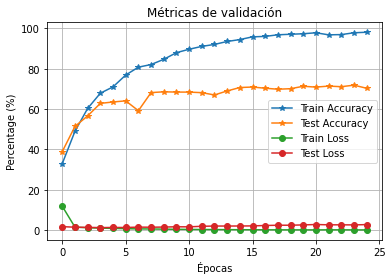

In [14]:
plt.plot(rtrain_accuracy, label="Train Accuracy", marker = '*')
plt.plot(rtest_accuracy, label="Test Accuracy", marker = '*')
plt.plot(rtrain_loss, label="Train Loss", marker = 'o')
plt.plot(rtest_loss, label="Test Loss", marker = 'o')

plt.title("Métricas de validación")
plt.xlabel("Épocas")
plt.ylabel("Percentage (%)")
plt.legend()
plt.grid()
plt.show()